#  Mini-Projet : Détection de phonèmes par analyse du signal vocal


# Nom du ~~binôme :~~ solo: Nohé Hinniger-Foray

L'objectif de ce projet consiste à détecter et reconnaître les phonèmes à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.



Vous disposez d'une base d'apprentissage et une base de test. Il faut reconnaître tous les phénomènes suivants :
$$'a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'$$


In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import librosa

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

Comme chaque fichier a une durée différente, on calcule la moyenne des MFCC sur toutes les fenêtres de discrétisation. 

La matrice de sortie est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 13.

In [5]:
# note: si erreur No module named 'pkg_resources' -> pip install setuptools
from os import listdir
from os.path import isfile, join
fichiers = [f for f in listdir("./Data/")]
sort_fichiers = sorted(fichiers)
DataMFCC=[]
label=[]
#print(sort_fichiers)

# Calcul des MFCC sur tous les fichiers de la base de données
for i in range(len(sort_fichiers)):
    # chargement du fichier audio
    y, sr = librosa.load("./Data/" + sort_fichiers[i])
    mfccBA = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=13)
    # Stockage et calcul du MFCC moyen pour le phonème
    DataMFCC.append(np.mean(mfccBA,axis=1))
    # Stockage de l'étiquette label
    label.append(i//10)

DataMFCC=np.asarray(DataMFCC)
label=np.asarray(label)
print('Dimension des données',DataMFCC.shape)
print(f"Nombre de fichiers: {len(sort_fichiers)}")

Dimension des données (90, 13)
Nombre de fichiers: 90


In [6]:
# Phonème associé à chaque valeur de label
# Nomlabel=['a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'] 
Nomlabel=['a','e','e_aigu','e_grave','i','o','o_ouvert','ou','u'] 

In [7]:
# Description des données 
unique, counts = np.unique(label, return_counts=True)


for i in range(unique.shape[0]):
    print('Label',unique[i],'correspond à ',Nomlabel[i],':',counts[i],'enregistrements');

Label 0 correspond à  a : 10 enregistrements
Label 1 correspond à  e : 10 enregistrements
Label 2 correspond à  e_aigu : 10 enregistrements
Label 3 correspond à  e_grave : 10 enregistrements
Label 4 correspond à  i : 10 enregistrements
Label 5 correspond à  o : 10 enregistrements
Label 6 correspond à  o_ouvert : 10 enregistrements
Label 7 correspond à  ou : 10 enregistrements
Label 8 correspond à  u : 10 enregistrements


###  Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisées.

In [8]:
# Séparation de l'ensemble de données en Base d'apprentissage et base de test
from sklearn.model_selection import train_test_split

def split_data(DataMFCC, label):
    X_train, X_test, y_train, y_test = train_test_split(DataMFCC, label, random_state=42,test_size=0.2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(DataMFCC, label)
print('Dimension Base d apprentissage :', X_train.shape)
print('Dimension Base de test :', X_test.shape)

Dimension Base d apprentissage : (72, 13)
Dimension Base de test : (18, 13)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [9]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros(len(np.unique(cluster_labels)))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred,label):
  # Correspondance entre la partition du clusterin y_pred et les classes de la vérité terrain label
  reference_labels = retrieve_info(y_pred,label)
  number_labels = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
    number_labels[i] = reference_labels[y_pred[i]]
  return number_labels


# Methodologie
Comme certaines methodes que nous allons utiliser sont non déterministes, et afin de pouvoir les comparer, nous allons utiliser chaque classifier de la même manière. Nous allons faire tourner chaque classifier 100 fois, et calculer la moyenne des scores et matrices de confusion obtenus (en les normalisant).
Aussi, afin d'analyser les erreurs, une matrice de confusion globale, elle aussi normalisée sera calculée tout au long de l'analyse.

In [10]:
# Fonction pour normaliser une matrice 2D
from numpy import newaxis
def normalize(mat):
    row_sums = mat.sum(axis=1)
    new_mat = mat / row_sums[:, newaxis]
    return new_mat

# Methodes supervisées
def run_supervised_classifier_once(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    score = accuracy_score(y_test, y_predicted)
    cm = confusion_matrix(y_true=y_test, y_pred=y_predicted)
    normalized_cm = normalize(cm)
    return score, normalized_cm

def run_supervised_classifier_n_times(clf, data=DataMFCC, n=100):
    scores = 0
    confusion_matrix = np.zeros((9, 9))
    for _ in range(n):
        X_train, X_test, y_train, y_test = split_data(data, label)
        score, cm = run_supervised_classifier_once(clf, X_train, X_test, y_train, y_test)
        scores += score
        confusion_matrix += cm
    return scores / n, confusion_matrix / n

def display_supervised_results(score, cm, description):
    print(f"Accuracy score: {score}")
    plt.figure(figsize=(9, 8))
    sns.heatmap(cm, annot=True, cmap="YlGnBu")
    plt.title(f"confusion matrix for {description}, accuracy: {score} (supervised)")
    plt.ylabel("expected label")
    plt.xlabel("predicted label")
    plt.show()

# Methodes non supervisées
def run_unsupervised_classifier_once(clf, data, label):
    y_predicted = clf.fit_predict(data)
    y_predicted_labelized = correspondance(y_predicted, label)
    score = accuracy_score(label, y_predicted_labelized)
    cm = confusion_matrix(y_true=label, y_pred=y_predicted_labelized)
    normalized_cm = normalize(cm)
    return score, normalized_cm, y_predicted_labelized

def run_unsupervised_classifier_n_times(clf, data=DataMFCC, n=100):
    scores = 0
    confusion_matrix = np.zeros((9, 9))
    for _ in range(n):
        score, cm, _ = run_unsupervised_classifier_once(clf, data, label)
        scores += score
        confusion_matrix += cm
    return scores / n, confusion_matrix / n

def display_unsupervised_results(score, cm, description):
    print(f"Accuracy score: {score}")
    plt.figure(figsize=(9, 8))
    sns.heatmap(cm, annot=True, cmap="YlGnBu")
    plt.title(f"confusion matrix for {description}, accuracy: {score} (unsupervised)")
    plt.ylabel("expected label")
    plt.xlabel("predicted label")
    plt.show()

global_confusion_matrix = np.zeros((9, 9))
number_of_additions = 0

def add_to_global_confusion_matrix(cm):
    global global_confusion_matrix
    global number_of_additions
    number_of_additions += 1
    global_confusion_matrix += normalize(cm)
    
def get_global_confusion_matrix():
    return global_confusion_matrix / number_of_additions

# Partie I : Classification des phonèmes sans prétraitement 

Réaliser une classification de ces phonèmes par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser le triangle voyellique présenté ci-après pour interpréter les résultats.

## Méthode supervisée  : Classification Bayesienne


Accuracy score: 1.0


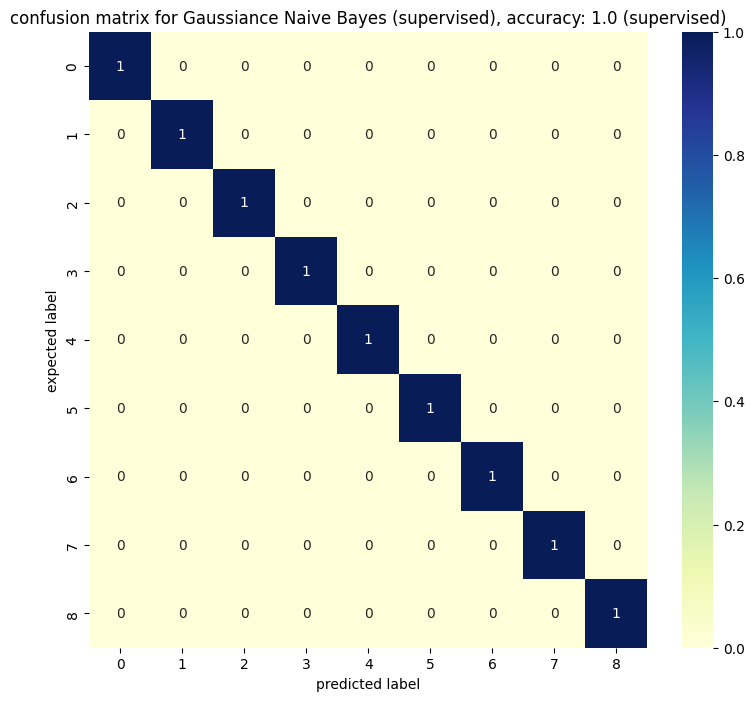

In [11]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
score, cm = run_supervised_classifier_n_times(classifier)
display_supervised_results(score, cm, "Gaussiance Naive Bayes (supervised)")
add_to_global_confusion_matrix(cm)

On voit que sur 100 itérations on a 100% de précision. Je trouve cela étonnant mais cette méthode simple semble très efficace pour ce problème.

## Méthode non supervisée : K-Means

using KMeans with 9 clusters
Accuracy score: 0.7415555555555554


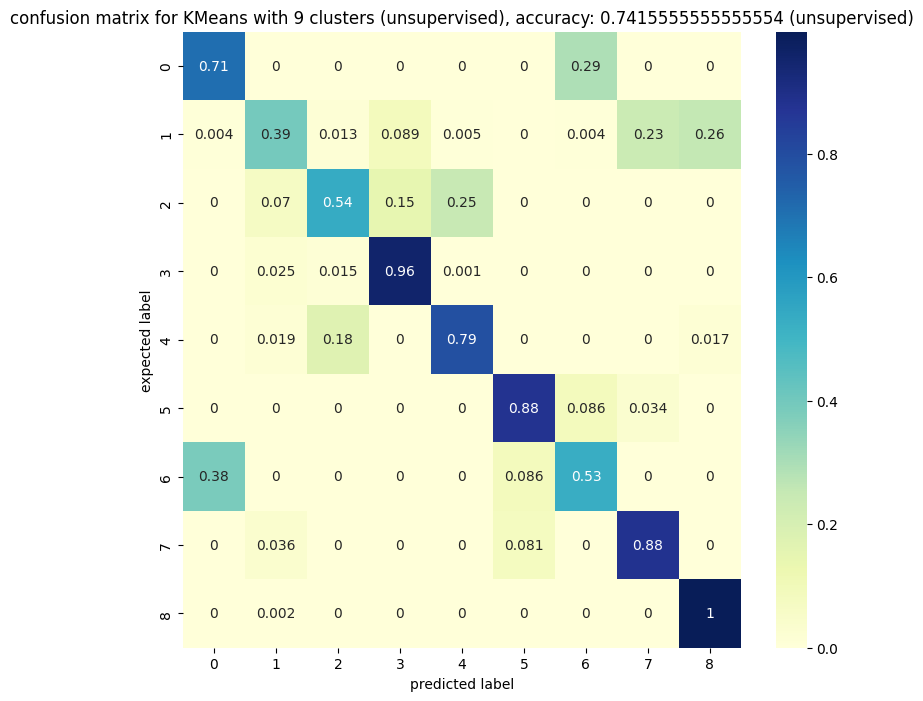

In [12]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.cluster import KMeans

# On cree autant de clusters que de labels (9)
n_clusters = len(Nomlabel) 
print(f"using KMeans with {n_clusters} clusters")
classifier = KMeans(n_clusters=n_clusters)
# On fit sur l'intégralité de la data (non supervisé)
score, cm = run_unsupervised_classifier_n_times(classifier)
display_unsupervised_results(score, cm, f"KMeans with {n_clusters} clusters (unsupervised)")
add_to_global_confusion_matrix(cm)

## Visualisation des clusters

Si on run la methode k-means une seule fois on peut voir en couleur les differents clusters. Cela est visuel mais peu intéréssant car on choisit arbitrairement 2 dimensions axes pour la visualisation (les 2 premières), alors que la data est sur 13 dimensions. Pour avoir une visualisation plus pertinente, on peut utiliser une méthode de réduction de dimension comme l'ACP (on abordera cela plus loin pour d'autres tests).

[]

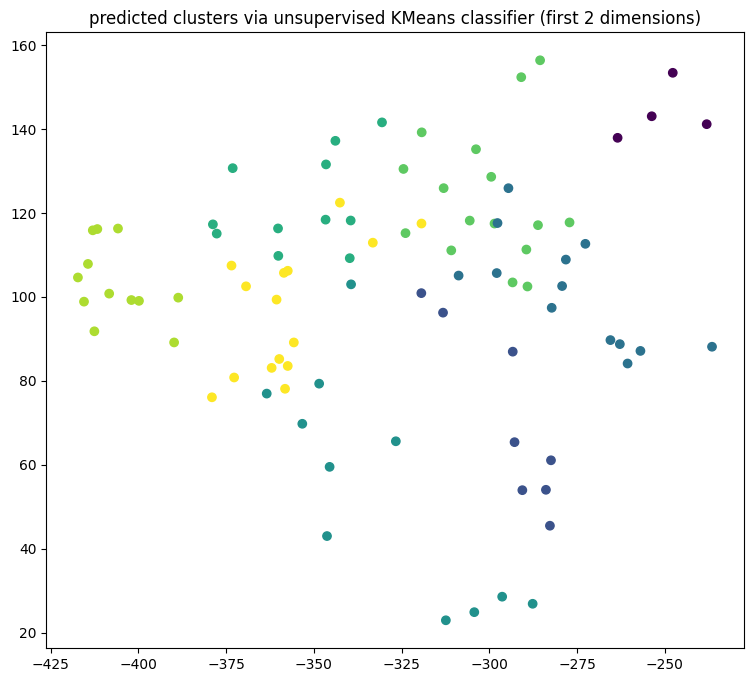

In [13]:

score, _, predicted = run_unsupervised_classifier_once(classifier, DataMFCC, label)

# Affichage des clusters
# Peu représentatif car en 2D, sur les deux premiers MFCC, on en extrait 13 en réalité
plt.figure(figsize=(9, 8))
plt.scatter(DataMFCC[:, 0], DataMFCC[:, 1], c=predicted)
plt.title("predicted clusters via unsupervised KMeans classifier (first 2 dimensions)")
plt.plot()


On obtient une accuracy moyenne de 0.75 pour KMeans.

## Méthode non supervisée 2 : Spectral clustering

Je voulais tester si un algorithme de clustering plus avancé pouvait donner de meilleurs résultats. J'ai donc choisi le spectral clustering.

using SpectralClustering with 9 clusters
Accuracy score: 0.733333333333334


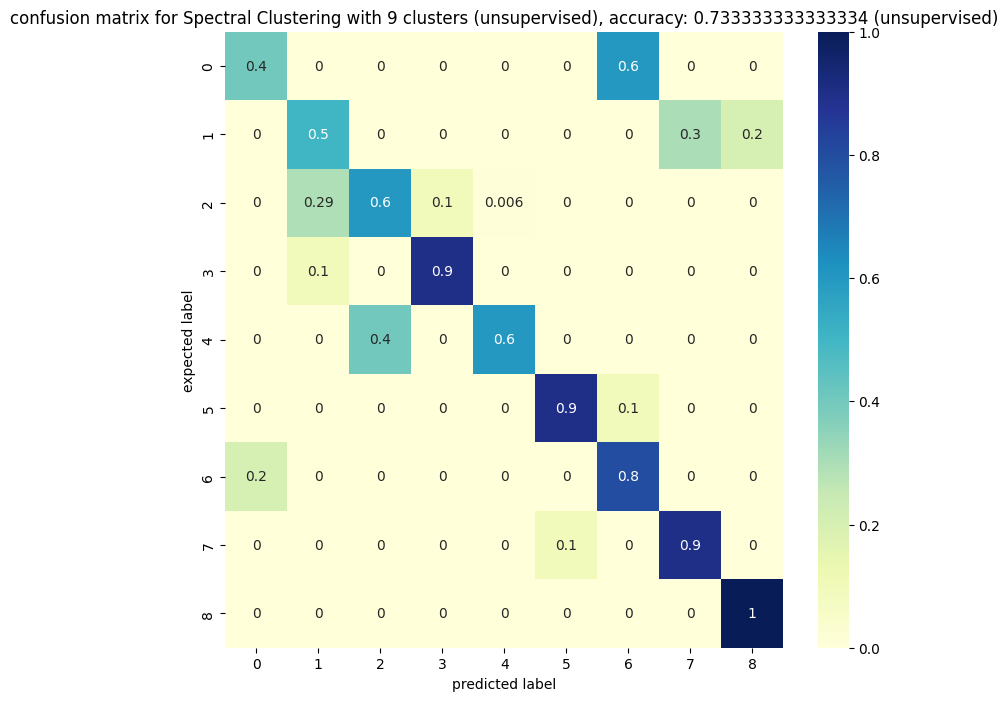

In [14]:
from sklearn.cluster import SpectralClustering

n_clusters = len(Nomlabel) 
print(f"using SpectralClustering with {n_clusters} clusters")

classifier = SpectralClustering(
    n_clusters=n_clusters,
    affinity="nearest_neighbors",
)
score, cm = run_unsupervised_classifier_n_times(classifier)
display_unsupervised_results(score, cm, f"Spectral Clustering with {n_clusters} clusters (unsupervised)")
add_to_global_confusion_matrix(cm)

On obtient une accuracy moyenne de 0.73 pour le spectal clustering. On voit donc que cette méthode est légérement moins adaptée au jeu de données que le KMeans simple, d'autant plus que le temps de calcul est plus long.

# Partie II : classification des phonèmes avec prétraitement 


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)




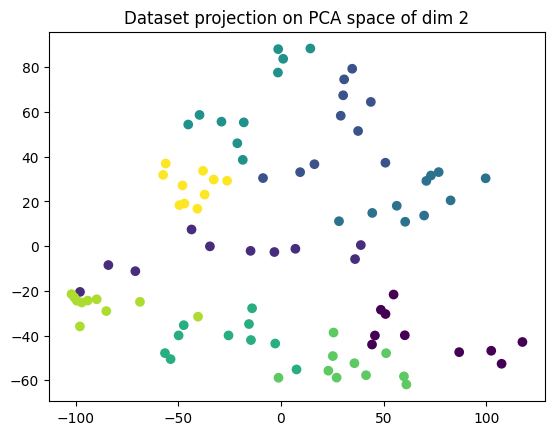

In [15]:
from sklearn.decomposition import PCA
dim=2
pca = PCA(dim)
pca_data = pca.fit_transform(DataMFCC)
plt.scatter(pca_data[:, 0], pca_data[:, 1],marker='o', c=label)
plt.title(f"Dataset projection on PCA space of dim {dim}")
plt.show()


On peut ensuite effectuer 100 iterations de la classification bayesienne sur le jeu de données réduit par ACP:

Accuracy score: 0.9444444444444432


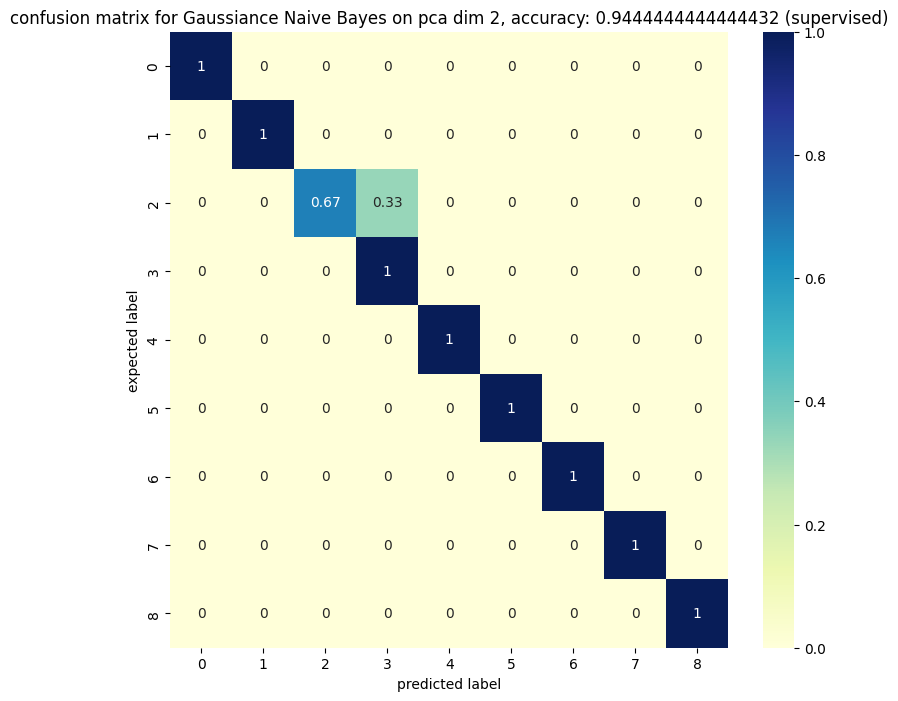

In [16]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
score, cm = run_supervised_classifier_n_times(classifier, pca_data)
display_supervised_results(score, cm, "Gaussiance Naive Bayes on pca dim 2")
add_to_global_confusion_matrix(cm)

On voit que la reduction en dimension 2 ajoute des erreurs (on passe de 100% à 94% de précision). En général je ne pense pas que l'ACP ait beaucoup d'intéret pour la classification bayesienne. Aussi nous avons arbitrairement choisi dim=2, nous allons voir plus loin si d'autres dimensions sont plus adaptées. On voit aussi que l'erreur est uniquement reportée sur un phonème. Le modele semble dans ce cas prédire un e_grave à la place d'un e_aigu. Cela semble plutot plausible phonétiquement parlant, car ces phonemes sont très proches (cf triangle voyellique a la fin du notebook).


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données 

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

KMeans avec reduction de dimension par ACP sur l'ensemble des données (dimensions = 2):

Accuracy score: 0.7015555555555557


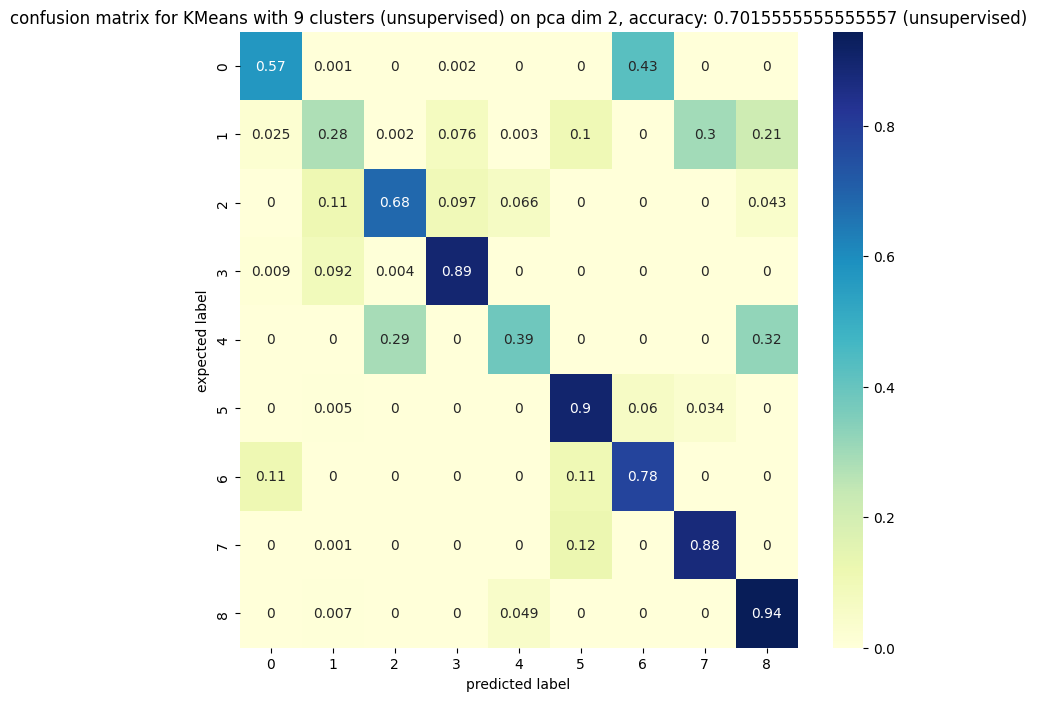

In [17]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.cluster import KMeans

# On cree autant de clusters que de labels (9), on pourrait virtuellement augmenter le score en augmentant le nombre de clusters mais cela n'aurait pas de sens
n_clusters = len(Nomlabel) 
classifier = KMeans(n_clusters=n_clusters)
# On fit sur l'intégralité de la data (non supervisé)
score, cm = run_unsupervised_classifier_n_times(classifier, pca_data)
display_unsupervised_results(score, cm, f"KMeans with {n_clusters} clusters (unsupervised) on pca dim 2")
add_to_global_confusion_matrix(cm)

Ici aussi on a une baisse d'accuracy (de 0.74 à 0.70). 

### Recherche de la meilleure dimension

dim = 2 à été choisi arbitrairement (et car utile pour représenter la donnée sur une image), mais on peut alors se poser la question: quelle et la réduction idéale pour la méthode non supervisée KMeans (on pourrait aussi tester avec la méthode supervisée) ?

Methodologie: comme KMeans est non déterministe (on obtiens un score qui varie a chaque run) je fit n_fit fois par dimension (dim) et je garde le score moyen.

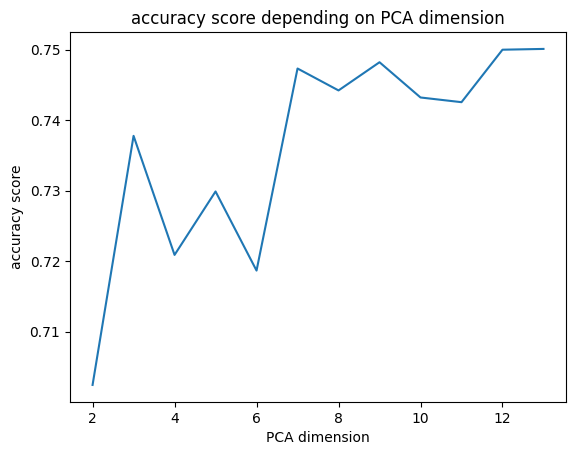

In [27]:
dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


def score_for_dim(dim):
    pca_data = PCA(dim).fit_transform(DataMFCC)
    classifier = KMeans(n_clusters=len(Nomlabel))
    score, _ = run_unsupervised_classifier_n_times(classifier, pca_data)
    return score

scores = [score_for_dim(dim) for dim in dims]
plt.plot(dims, scores)
plt.title("accuracy score depending on PCA dimension")
plt.ylabel("accuracy score")
plt.xlabel("PCA dimension")
plt.show()


Il semble y avoir une tendance pour laquelle l'accuracy score augmente avec la dimension de la PCA, mais cela n'est pas toujours vrai.
dim = 3 semble aussi efficace. Globalement, la variation est assez faible.

### Recherche de la meilleure reduction de dimension (méthode supervisée)

Je répete le meme procédé (par curiosité), sur la méthode supervisée (GaussianBayesian)

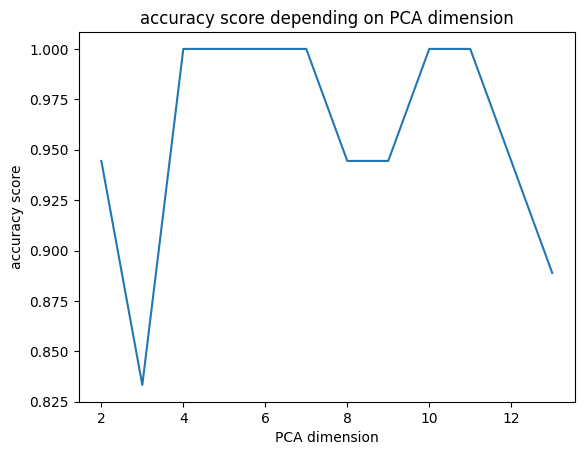

In [31]:
dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


def score_for_dim(dim):
    pca_data = PCA(dim).fit_transform(DataMFCC)
    classifier = GaussianNB()
    score, _ = run_supervised_classifier_n_times(classifier, pca_data)
    return score

scores = [score_for_dim(dim) for dim in dims]
plt.plot(dims, scores)
plt.title("accuracy score depending on PCA dimension")
plt.ylabel("accuracy score")
plt.xlabel("PCA dimension")
plt.show()




On voit un pattern étonnant ici, on semble avoir une accuracy maximale (=1) pour dim entre 4 et 11, sauf 8 et 9.

## Partie III : Analyse des résultats 

En compilant toutes les matrices de confusion en une seule, (en effectuant une moyenne pondérée des matrices), puis en soustrayant la diagonale, on obtient une matrice représentant les erreurs et leur fréquence.

Text(0.5, 58.7222222222222, 'predicted label')

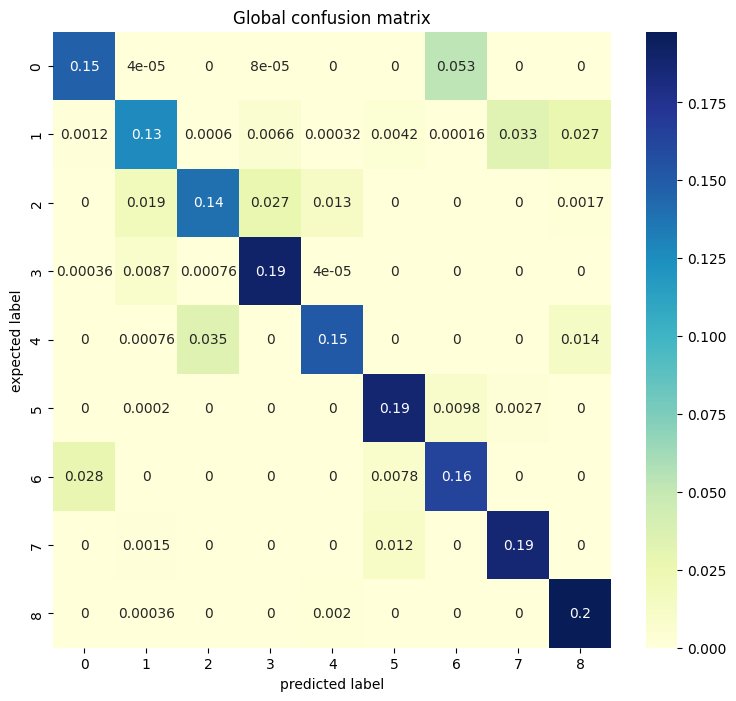

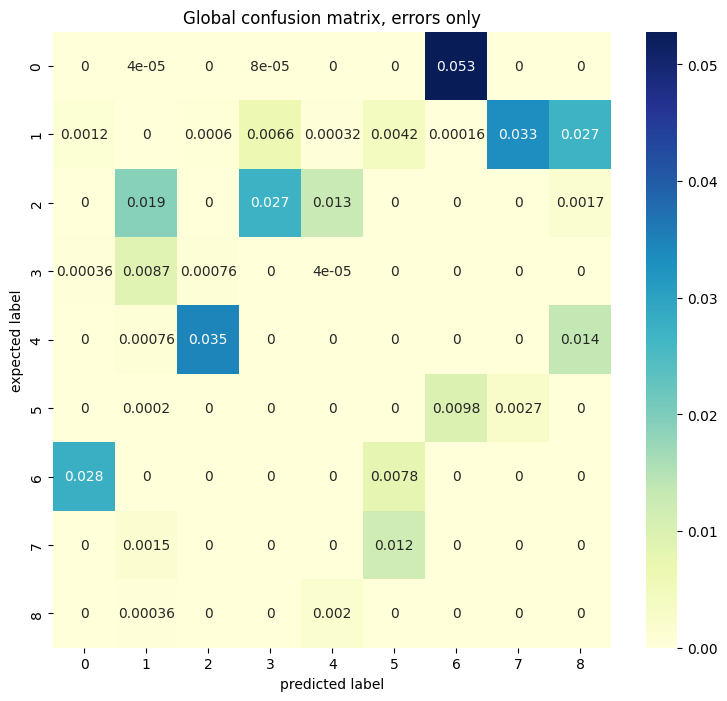

In [33]:
plt.figure(figsize=(9, 8))
global_confusion_matrix = get_global_confusion_matrix()
sns.heatmap(global_confusion_matrix, annot=True, cmap="YlGnBu")
plt.title('Global confusion matrix')
plt.ylabel("expected label")
plt.xlabel("predicted label")

gcm_errors = global_confusion_matrix.copy()
np.fill_diagonal(gcm_errors, 0)
plt.figure(figsize=(9, 8))
sns.heatmap(gcm_errors, annot=True, cmap="YlGnBu")
plt.title('Global confusion matrix, errors only')
plt.ylabel("expected label")
plt.xlabel("predicted label")



<img src="triangle_voyellique.jpg" width="600" height="600"  >

In [34]:
# errors list(expected, predicted, freq) sorted by frequency
errors = []
for i in range(gcm_errors.shape[0]):
  for j in range(gcm_errors.shape[1]):
    if gcm_errors[i, j] > 0:
      errors.append((i, j, gcm_errors[i, j]))

errors = sorted(errors, key=lambda x: x[2], reverse=True)

# Errors mapped to label names
errors_mapped = [(Nomlabel[i], Nomlabel[j], freq) for i, j, freq in errors]

# Pretty display of errors 
for i, j, freq in errors_mapped:
  print(f"Expected: {i}, predicted: {j}, frequency: {freq}")

Expected: a, predicted: o_ouvert, frequency: 0.05280000000000007
Expected: i, predicted: e_aigu, frequency: 0.03459999999999995
Expected: e, predicted: ou, frequency: 0.033280000000000046
Expected: o_ouvert, predicted: a, frequency: 0.027839999999999997
Expected: e_aigu, predicted: e_grave, frequency: 0.027053333333333308
Expected: e, predicted: u, frequency: 0.026839999999999975
Expected: e_aigu, predicted: e, frequency: 0.019000000000000003
Expected: i, predicted: u, frequency: 0.01360000000000001
Expected: e_aigu, predicted: i, frequency: 0.012800000000000006
Expected: ou, predicted: o, frequency: 0.012119999999999975
Expected: o, predicted: o_ouvert, frequency: 0.009839999999999982
Expected: e_grave, predicted: e, frequency: 0.00867999999999999
Expected: o_ouvert, predicted: o, frequency: 0.00783999999999999
Expected: e, predicted: e_grave, frequency: 0.006599999999999997
Expected: e, predicted: o, frequency: 0.004199999999999998
Expected: o, predicted: ou, frequency: 0.00271999999

Pour rappel:
```
Label 0 correspond à  a : 10 enregistrements
Label 1 correspond à  e : 10 enregistrements
Label 2 correspond à  e_aigu : 10 enregistrements
Label 3 correspond à  e_grave : 10 enregistrements
Label 4 correspond à  i : 10 enregistrements
Label 5 correspond à  o : 10 enregistrements
Label 6 correspond à  o_ouvert : 10 enregistrements
Label 7 correspond à  ou : 10 enregistrements
Label 8 correspond à  u : 10 enregistrements
```

On voit alors que l'erreur la plus commune est de predire un o_ouvert à la place d'un a. C'est d'ailleurs quasiment l'unique source d'erreur pour le a.
D'autres lignes ont des erreurs beaucoup plus diverses, par exemple on voir que le e (eu) a des erreurs plus diverses (sur differentes colonnes).
On voit que les erreurs sont globalement proches sur le triangle, et plutot sur un axe vertical. Cela est choérent, le modele se trompe sur des phonemes proches au son, et donc proches sur le triangle voyellique. L'axe vertical peut aussi s'expliquer je pense car la différence entre les phonemes est plus subtile sur cet axe, alors que l'axe horizontal est facile a retranscrire avec uniquement la hauteur du son.